In [59]:
import ast
import json
import logging
import time
from dataclasses import dataclass
from datetime import datetime
from typing import List, Dict, Optional, Tuple


import numpy as np
import pandas as pd
import requests
import talib as ta
import yfinance as yf
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry


# Torch / Transformers for sentiment
import torch
from torch.nn.functional import softmax
from transformers import AutoModelForSequenceClassification, AutoTokenizer


# Modeling
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (LSTM, Bidirectional, Dense, Dropout, GRU)
from tensorflow.keras.models import Sequential

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Visualization (optional)
import matplotlib.pyplot as plt
pd.set_option('display.float_format', '{:.2f}'.format)

### Scraping News Data

Platform yang dipilih adalah Detik.com, dengan metode scraping menggunakan BeautifulSoup.

In [ ]:
MONTH_MAP = {
    "Jan": "Jan", "Feb": "Feb", "Mar": "Mar", "Apr": "Apr",
    "Mei": "May", "Jun": "Jun", "Jul": "Jul", "Agu": "Aug",
    "Sep": "Sep", "Okt": "Oct", "Nov": "Nov", "Des": "Dec"
}

def parse_date(date_str):
    if not date_str:
        return None
    try:
        parts = date_str.split(",")[-1].strip().replace("WIB", "").strip()
        for indo, eng in MONTH_MAP.items():
            if f" {indo} " in parts:
                parts = parts.replace(f" {indo} ", f" {eng} ")
                break
        return datetime.strptime(parts, "%d %b %Y %H:%M")
    except Exception as e:
        print(f"Failed to parse date: {date_str} ({e})")
        return None

def create_session(retries=5, backoff=0.5):
    session = requests.Session()
    retry = Retry(
        total=retries,
        read=retries,
        connect=retries,
        backoff_factor=backoff,
        status_forcelist=[500, 502, 503, 504],
        allowed_methods=["HEAD", "GET", "OPTIONS"]
    )
    adapter = HTTPAdapter(max_retries=retry)
    session.mount("https://", adapter)
    session.mount("http://", adapter)
    return session

def scrape_detik(query="bank+mandiri", start_date="01/01/2025", end_date="22/09/2025", site_ids=[29], max_pages=1000):
    results = []
    session = create_session()
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                      "AppleWebKit/537.36 (KHTML, like Gecko) "
                      "Chrome/122.0.0.0 Safari/537.36"
    }

    for site_id in site_ids:
        print(f"Scraping siteid={site_id} ...")
        for page in range(1, max_pages + 1):
        # for page in range(1, 11):
            url = f"https://www.detik.com/search/searchall?query={query}&result_type=relevansi&siteid={site_id}&fromdatex={start_date}&todatex={end_date}&page={page}"
            try:
                r = session.get(url, headers=headers, timeout=15)
                r.raise_for_status()
            except requests.exceptions.RequestException as e:
                print(f"Error fetching search page {page}: {e}")
                continue

            soup = BeautifulSoup(r.text, "html.parser")
            articles = soup.find_all("article")
            if not articles:
                break

            for art in articles:
                a_tag = art.find("a")
                if not a_tag:
                    continue
                link = a_tag.get("href")

                try:
                    art_resp = session.get(link, headers=headers, timeout=15)
                    art_resp.raise_for_status()
                    soup2 = BeautifulSoup(art_resp.text, "html.parser")

                    title_tag = soup2.find("h1", class_="detail__title")
                    title = title_tag.get_text(strip=True) if title_tag else None

                    author_tag = soup2.find("div", class_="detail__author")
                    author = author_tag.get_text(strip=True) if author_tag else None

                    date_tag = soup2.find("div", class_="detail__date")
                    date = parse_date(date_tag.get_text(strip=True)) if date_tag else None

                    paragraphs = soup2.select("div.detail__body-text p")
                    content = " ".join([p.get_text(" ", strip=True) for p in paragraphs])

                    label_tag = soup2.find("span", class_="detail__label")
                    label = label_tag.get_text(strip=True) if label_tag else None

                    tag_div = soup2.find("div", class_="detail__body-tag")
                    tags = ", ".join([t.get_text(strip=True) for t in tag_div.find_all("a")]) if tag_div else None

                    results.append({
                        "siteid": site_id,
                        "title": title,
                        "author": author,
                        "date": date,
                        "label": label,
                        "content": content,
                        "tags": tags,
                        "url": link
                    })
                    time.sleep(0.5)

                except requests.exceptions.RequestException as e:
                    print(f"Error fetching article {link}: {e}")
                    continue

            print(f"✅ Page {page} done, total articles: {len(results)}")

    return results


In [ ]:
queries = [
    "bank bca",
    "bank jago",
    "bank bsi",
    "bank bni",
    "bank btn",
    "bank bri",
    "telkom",
    "goto",
    "isat",
    "xl",
    "smartfren"
]

all_results = []

for q in queries:
    print(f"🔍 Scraping query: {q}")
    articles = scrape_detik(
        query=q.replace(" ", "+"),  
        # start_date="01/01/2025",
        # end_date="21/09/2025",
        site_ids=[29],          
        max_pages=1000
    )
    for a in articles:
        a["query"] = q
    all_results.extend(articles)

with open("detik_bank_mandiri20250105.json", "w", encoding="utf-8") as f:
    json.dump(articles, f, ensure_ascii=False, indent=4)

# df = pd.DataFrame(all_results)
# df.to_csv("all_banks_news.csv", index=False, encoding="utf-8-sig")
# print(f"Total articles scraped: {len(df)}")

### News Data

Train news data dengan model IndoFinTech  
Source: [arXiv:2310.09736](https://arxiv.org/pdf/2310.09736)  
Model ini (IndoFinTech/IndoFinBERT) sudah dilatih dengan dataset teks finance berbahasa Indonesia, termasuk berita finansial.

In [ ]:
# Muat model IndoBERT yang telah dilatih untuk analisis sentimen
# model_name = 'intanm/mlm-20230510-indobert-large-p1-001-pt2'
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name)

model_name = 'intanm/mlm-20230510-indobert-large-p1-001-pt2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def predict_sentiment_batch(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs).logits

    probs = softmax(logits, dim=-1)

    predictions = probs.argmax(dim=-1)  
    prob_values = probs.tolist()  

    labels = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}

    result = []
    for i in range(len(predictions)):
        predicted_label = labels[min(2, max(0, predictions[i].item()))]
        highest_prob = max(prob_values[i]) 
        result.append((predicted_label, highest_prob, prob_values[i]))

    return result

df_final = pd.read_excel("df_final.xlsx")

batch_size = 1000 
results = []

for i in range(0, len(df_final), batch_size):
    print(f"Batch : {i}")

    batch_texts = df_final['title'].iloc[i:i+batch_size].astype(str).tolist()
    batch_results = predict_sentiment_batch(batch_texts)
    results.extend(batch_results) 

df_final.loc[:len(results)-1, ['sentiment_label', 'sentiment_score', 'probabilities']] = pd.DataFrame(results, columns=['sentiment_label', 'sentiment_score', 'probabilities'])

print(df_final[['title', 'sentiment_label', 'sentiment_score']].head(10))

In [3]:
df_news = pd.read_excel("df_final_sentiment.xlsx")
df_news.head()

,siteid,title,author,date,label,content,tags,url,query,sentiment_label,sentiment_score,probabilities
0,29,Pencairan Kredit Bank BUMN ke Kopdes Merah Put...,Anisa Indraini -detikFinance,2025-09-22 22:34:00,detikFinance,Pemerintah mempercepat pencairan kredit untuk ...,"pencairan kredit, bank bumn, koperasi desa, ko...",https://finance.detik.com/moneter/d-8125302/pe...,bank bca,Netral,0.277207,"[0.19799505174160004, 0.2772073745727539, 0.18..."
1,29,Plt Bos LPS Minta Bank Hati-hati Salurkan Kred...,Andi Hidayat -detikFinance,2025-09-22 18:52:00,detikFinance,Plt Ketua Dewan Komisioner Lembaga Penjamin Si...,"lps, kredit, kehati-hatian, non-performing loa...",https://finance.detik.com/moneter/d-8125041/pl...,bank bca,Positif,0.304314,"[0.22463765740394592, 0.15945926308631897, 0.1..."
2,29,Bank Sentral ASEAN Kompak Perkuat Integrasi Ke...,Aulia Damayanti -detikFinance,2025-09-20 22:30:00,detikFinance,Bank sentral negara ASEAN menyatukan langkah u...,"bank sentral asean, integrasi keuangan, ketaha...",https://finance.detik.com/moneter/d-8121878/ba...,bank bca,Netral,0.296829,"[0.1630878448486328, 0.29682889580726624, 0.22..."
3,29,Bank Digital Banyak Dipakai Gen Z dan Milenial...,Amanda Christabel -detikFinance,2025-09-20 22:00:00,detikFinance,Pertumbuhan perbankan digital di Indonesia men...,"milenial, gen z, bank digital, keamanan finansial",https://finance.detik.com/moneter/d-8121824/ba...,bank bca,Netral,0.271335,"[0.12217865884304047, 0.27133506536483765, 0.2..."
4,29,bank bjb Pastikan Dukung Program 'Imah Merenah...,Dea Duta Aulia -detikFinance,2025-09-20 16:26:00,detikFinance,bank bjb mendukung penuh peluncuran inisiatif ...,"bank bjb, imah merenah hirup tumaninah, flpp",https://finance.detik.com/berita-ekonomi-bisni...,bank bca,Positif,0.250945,"[0.19164171814918518, 0.20646454393863678, 0.2..."


### Count news data

In [4]:
# df_news.info()
df_news.groupby([df_news["date"].dt.to_period("M"),"query","sentiment_label"])[["title"]].count()

title
date    query               sentiment_label       
2025-01 astra               Positif              1
        astra international Negatif             15
                            Netral              20
                            Positif             32
        bank bca            Negatif             62
...                                            ...
2025-09 telkom              Positif              6
        united tractors     Negatif              3
                            Netral               1
                            Positif              1
        xl                  Positif              1

[437 rows x 1 columns]

In [5]:
df_news["query"] = df_news["query"].str.replace("xl","xlsmart")
df_news["query"] = df_news["query"].str.replace("astra","astra international")
df_news["query"] = df_news["query"].str.replace("astra international international","astra international")

In [6]:
df_news["date_only"] = df_news["date"].dt.date
df_news.head()

,siteid,title,author,date,label,content,tags,url,query,sentiment_label,sentiment_score,probabilities,date_only
0,29,Pencairan Kredit Bank BUMN ke Kopdes Merah Put...,Anisa Indraini -detikFinance,2025-09-22 22:34:00,detikFinance,Pemerintah mempercepat pencairan kredit untuk ...,"pencairan kredit, bank bumn, koperasi desa, ko...",https://finance.detik.com/moneter/d-8125302/pe...,bank bca,Netral,0.277207,"[0.19799505174160004, 0.2772073745727539, 0.18...",2025-09-22
1,29,Plt Bos LPS Minta Bank Hati-hati Salurkan Kred...,Andi Hidayat -detikFinance,2025-09-22 18:52:00,detikFinance,Plt Ketua Dewan Komisioner Lembaga Penjamin Si...,"lps, kredit, kehati-hatian, non-performing loa...",https://finance.detik.com/moneter/d-8125041/pl...,bank bca,Positif,0.304314,"[0.22463765740394592, 0.15945926308631897, 0.1...",2025-09-22
2,29,Bank Sentral ASEAN Kompak Perkuat Integrasi Ke...,Aulia Damayanti -detikFinance,2025-09-20 22:30:00,detikFinance,Bank sentral negara ASEAN menyatukan langkah u...,"bank sentral asean, integrasi keuangan, ketaha...",https://finance.detik.com/moneter/d-8121878/ba...,bank bca,Netral,0.296829,"[0.1630878448486328, 0.29682889580726624, 0.22...",2025-09-20
3,29,Bank Digital Banyak Dipakai Gen Z dan Milenial...,Amanda Christabel -detikFinance,2025-09-20 22:00:00,detikFinance,Pertumbuhan perbankan digital di Indonesia men...,"milenial, gen z, bank digital, keamanan finansial",https://finance.detik.com/moneter/d-8121824/ba...,bank bca,Netral,0.271335,"[0.12217865884304047, 0.27133506536483765, 0.2...",2025-09-20
4,29,bank bjb Pastikan Dukung Program 'Imah Merenah...,Dea Duta Aulia -detikFinance,2025-09-20 16:26:00,detikFinance,bank bjb mendukung penuh peluncuran inisiatif ...,"bank bjb, imah merenah hirup tumaninah, flpp",https://finance.detik.com/berita-ekonomi-bisni...,bank bca,Positif,0.250945,"[0.19164171814918518, 0.20646454393863678, 0.2...",2025-09-20


In [7]:
news_to_ticker_map = {
    "bank bca": "BBCA.JK",
    "bank jago": "ARTO.JK",
    "bank bsi": "BRIS.JK",  
    "bank bni": "BBNI.JK",
    "bank btn": "BBTN.JK",
    "bank bri": "BBRI.JK",
    "bank mandiri": "BMRI.JK",
    "telkom": "TLKM.JK",
    "goto": "GOTO.JK",
    "isat": "ISAT.JK",
    "xlsmart": "EXCL.JK",
    "smartfren": "EXCL.JK",
    "astra international": "ASII.JK",
    "united tractors": "UNTR.JK",
    "gudang garam": "GGRM.JK",
    "indofood": "INDF.JK",
    "sampoerna": "HMSP.JK",
    "pertamina": "PGEO.JK",  
    "unilever": "UNVR.JK"
}

df_news["Ticker"] = df_news["query"].map(news_to_ticker_map)

# df_news["query"] = df_news["query"].upper()
df_news[["date_only", "Ticker", "query", "sentiment_label", "sentiment_score"]]

,date_only,Ticker,query,sentiment_label,sentiment_score
0,2025-09-22,BBCA.JK,bank bca,Netral,0.277207
1,2025-09-22,BBCA.JK,bank bca,Positif,0.304314
2,2025-09-20,BBCA.JK,bank bca,Netral,0.296829
3,2025-09-20,BBCA.JK,bank bca,Netral,0.271335
4,2025-09-20,BBCA.JK,bank bca,Positif,0.250945
...,...,...,...,...,...
28780,2025-05-17,UNVR.JK,unilever,Negatif,0.235363
28781,2025-07-30,UNVR.JK,unilever,Positif,0.283944
28782,2025-07-10,UNVR.JK,unilever,Negatif,0.216034
28783,2025-03-18,UNVR.JK,unilever,Negatif,0.209470


In [8]:
df_news.rename(columns={"date":"datetime",
                      "date_only":"Date"}, inplace=True)
df_news["Date"] = pd.to_datetime(df_news["Date"])

#### Normalize Sentiment Score

In [9]:
df_news["probabilities"] = df_news["probabilities"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

print(df_news["probabilities"].iloc[0])
print(type(df_news["probabilities"].iloc[0]))
print(len(df_news["probabilities"].iloc[0]))

[0.19799505174160004, 0.2772073745727539, 0.1843424141407013, 0.196031853556633, 0.14442326128482819]
<class 'list'>
5


In [10]:
def normalize_from_probs_5(probs):
    """
    probs: [p_very_neg, p_neg, p_neu, p_pos, p_very_pos]
    return: sentiment score in [-1, 1]
    """
    if not isinstance(probs, (list, tuple, np.ndarray)):
        return None
    if len(probs) != 5:
        return None
    
    weights = np.array([-1, -0.5, 0, 0.5, 1])
    probs = np.array(probs, dtype=float)
    return float(np.dot(probs, weights))

df_news["sentiment_norm"] = df_news["probabilities"].apply(normalize_from_probs_5)

In [11]:
daily_sentiment = (
    df_news.groupby(["Ticker", "Date"]).agg(
        num_news=("title", "count"),
        avg_score=("sentiment_norm", "mean"),
        majority_sentiment=("sentiment_label", lambda x: x.value_counts().idxmax())
    ).reset_index()
)

In [13]:
daily_sentiment["avg_score"].min()

-0.1996438056230545

In [14]:
daily_sentiment

,Ticker,Date,num_news,avg_score,majority_sentiment
0,ARTO.JK,2025-01-02,8,-0.031130,Positif
1,ARTO.JK,2025-01-03,4,-0.041022,Netral
2,ARTO.JK,2025-01-04,8,-0.051859,Positif
3,ARTO.JK,2025-01-05,20,-0.074445,Positif
4,ARTO.JK,2025-01-06,8,-0.016857,Positif
...,...,...,...,...,...
2707,UNVR.JK,2025-07-30,1,-0.005506,Positif
2708,UNVR.JK,2025-07-31,4,-0.069927,Negatif
2709,UNVR.JK,2025-08-01,1,-0.094097,Negatif
2710,UNVR.JK,2025-08-13,1,-0.073494,Positif


In [15]:
stock = df_news["query"].unique()

In [16]:
stock

array(['bank bca', 'bank jago', 'bank bsi', 'bank bni', 'bank btn',
       'bank bri', 'telkom', 'goto', 'isat', 'xlsmart', 'smartfren',
       'bank mandiri', 'bank_mandiri', 'astra international',
       'united tractors', 'gudang garam', 'indofood', 'sampoerna',
       'pertamina', 'unilever'], dtype=object)

In [44]:
!pip install blosc2==2.0.0

  Obtaining dependency information for blosc2==2.0.0 from https://files.pythonhosted.org/packages/03/d0/685258d475e09d8884d64c8a1eb90a3428fbba782e60b7926f9fdb82c297/blosc2-2.0.0-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
    --------------------------------------- 0.0/1.9 MB 667.8 kB/s eta 0:00:03
   -- ------------------------------------- 0.1/1.9 MB 1.0 MB/s eta 0:00:02
   ----- ---------------------------------- 0.3/1.9 MB 1.8 MB/s eta 0:00:01
   --------- ------------------------------ 0.5/1.9 MB 2.5 MB/s eta 0:00:01
   ------------- -------------------------- 0.7/1.9 MB 3.0 MB/s eta 0:00:01
   --------------------- ------------------ 1.0/1.9 MB 3.6 MB/s eta 0:00:01
   ---------------------------- ----------- 1.4/1.9 MB 4.4 MB/s eta 0:00:01
   ---------------------------- ----------- 1.4/1.9 MB 4.4 MB/s eta 0:00:01
   ---------------------------- -------

In [45]:
!pip install ta-lib

In [48]:
!pip install yfinance

  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/16/bf/7c0c89ff8ba53592b9cb5157f70e90d8bbb04d60094fc4f10035e158b981/yfinance-0.2.66-py2.py3-none-any.whl.metadata
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for frozendict>=2.3.4 from https://files.pythonhosted.org/packages/04/13/d9839089b900fa7b479cce495d62110cddc4bd5630a04d8469916c0e79c5/frozendict-2.4.6-py311-none-any.whl.metadata
  Using cached frozendict-2.4.6-py311-none-any.whl.metadata (23 kB)
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     ---------------------------------------- 10.2/949.2 kB ? eta -:--:--
     ---------------------------------------- 10.2/949.2 kB ? eta -:--:--
     - ----------------------------------- 30.7/949.2 kB 325.1 kB/s eta 0:00:03
     -- ---------------------------------- 61.4/949.2 kB 409.6 kB/s eta 0:00:03
     --- --------------------

In [17]:
tickers = ["BMRI.JK", "BBCA.JK", "ARTO.JK", "BRIS.JK", "BBNI.JK", "BBTN.JK", "BBRI.JK","TLKM.JK", "GOTO.JK", "ISAT.JK", 
           "EXCL.JK", "ASII.JK", "UNTR.JK", "PGEO.JK", "UNVR.JK", "INDF.JK", "HMSP.JK", "GGRM.JK"]

df_stock = yf.download(tickers, start="2025-01-01", end="2025-09-22", group_by="ticker")

df_stock = df_stock.stack(level=0).reset_index()

df_stock = df_stock.rename(columns={"level_1": "Ticker"})

# df = df[["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"]]

C:\Users\MELANI\AppData\Local\Temp\ipykernel_24056\481767292.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_stock = yf.download(tickers, start="2025-01-01", end="2025-09-22", group_by="ticker")
[*********************100%***********************]  18 of 18 completed


In [18]:
df_stock.groupby('Ticker')['Date'].count()

Ticker
ARTO.JK    166
ASII.JK    166
BBCA.JK    166
BBNI.JK    166
BBRI.JK    166
BBTN.JK    166
BMRI.JK    166
BRIS.JK    166
EXCL.JK    166
GGRM.JK    166
GOTO.JK    166
HMSP.JK    166
INDF.JK    166
ISAT.JK    166
PGEO.JK    166
TLKM.JK    166
UNTR.JK    166
UNVR.JK    166
Name: Date, dtype: int64

In [19]:
df_stock['Date'].max()

Timestamp('2025-09-19 00:00:00')

### Data Stock yang telah didownload dari yfinance

In [22]:
df_stock

Price,Date,Ticker,Close,High,Low,Open,Volume
0,2025-01-02,ARTO.JK,2430.000000,2490.000000,2410.000000,2490.000000,1689300
1,2025-01-02,ASII.JK,4636.296387,4655.028897,4589.465110,4598.831365,17924000
2,2025-01-02,BBCA.JK,9604.477539,9604.477539,9361.940227,9361.940227,38124800
3,2025-01-02,BBNI.JK,4212.654297,4212.654297,4001.562687,4001.562687,56985400
4,2025-01-02,BBRI.JK,3979.114746,3988.566325,3865.695798,3875.147377,181361700
...,...,...,...,...,...,...,...
2983,2025-09-19,ISAT.JK,1890.000000,1900.000000,1815.000000,1845.000000,14833700
2984,2025-09-19,PGEO.JK,1340.000000,1345.000000,1305.000000,1310.000000,48010900
2985,2025-09-19,TLKM.JK,3230.000000,3300.000000,3160.000000,3210.000000,113834400
2986,2025-09-19,UNTR.JK,26750.000000,26775.000000,26300.000000,26625.000000,3614500


In [23]:
df_stock = df_stock.sort_values(by=["Ticker","Date"])

def add_indicators(group):
    group['DR'] = group['Close'].pct_change() * 100
    group['AO'] = ta.EMA(group['Close'], timeperiod=5) - ta.EMA(group['Close'], timeperiod=34)
    group['RSI'] = ta.RSI(group['Close'], timeperiod=14)
    group['ATR'] = ta.ATR(group['High'], group['Low'], group['Close'], timeperiod=14)
    group['ADX'] = ta.ADX(group['High'], group['Low'], group['Close'], timeperiod=14)
    aroondown, aroonup = ta.AROON(group['High'], group['Low'], timeperiod=14)
    group['AroonDown'] = aroondown
    group['AroonUp'] = aroonup
    return group

df_stock = df_stock.groupby("Ticker", group_keys=False).apply(add_indicators)

### Seasonal Data

In [24]:
df_stock['DayOfWeek'] = df_stock["Date"].dt.dayofweek  
df_stock['DayOfMonth'] = df_stock["Date"].dt.day 
df_stock['Month'] = df_stock["Date"].dt.month
df_stock['Quarter'] = df_stock["Date"].dt.quarter

Sesuai dengan yang di paper, seasonal data akan di encode menggunakan teknik One Hot Encoding.

In [25]:
df_stock = pd.get_dummies(df_stock, columns=['DayOfWeek'], prefix='DayOfWeek')
df_stock = pd.get_dummies(df_stock, columns=['DayOfMonth'], prefix='DayOfMonth')
df_stock = pd.get_dummies(df_stock, columns=['Month'], prefix='Month')
df_stock = pd.get_dummies(df_stock, columns=['Quarter'], prefix='Quarter')

Mapping, atau standardize ticker dengan nama company.

In [26]:
ticker_name_map = {
    "ARTO.JK": "Bank Jago Tbk",
    "ASII.JK": "Astra International Tbk",
    "BBCA.JK": "Bank Central Asia Tbk",
    "BBNI.JK": "Bank Negara Indonesia Tbk",
    "BBRI.JK": "Bank Rakyat Indonesia Tbk",
    "BBTN.JK": "Bank Tabungan Negara Tbk",
    "BMRI.JK": "Bank Mandiri Tbk",
    "BRIS.JK": "Bank Syariah Indonesia Tbk",
    "ISAT.JK": "Indosat Ooredoo Hutchison Tbk",
    "EXCL.JK": "XLSmart",
    "TLKM.JK": "Telkom Indonesia Tbk",
    "GOTO.JK": "Goto Gojek Tokopedia Tbk",
    "UNTR.JK": "United Tractors Tbk",
    "PGEO.JK": "Pertamina Geothermal Energy",
    "UNVR.JK": "Unilever Indonesia Tbk",
    "INDF.JK": "Indofood Sukses Makmur Tbk",
    "HMSP.JK": "HM Sampoerna Tbk",
    "GGRM.JK": "Gudang Garam Tbk"
}

df_stock["Company"] = df_stock["Ticker"].map(ticker_name_map)

In [27]:
df_stock.head()

,Date,Ticker,Close,High,Low,Open,Volume,DR,AO,RSI,...,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Quarter_1,Quarter_2,Quarter_3,Company
0,2025-01-02,ARTO.JK,2430.0,2490.0,2410.0,2490.0,1689300,NaN,NaN,NaN,...,False,False,False,False,False,False,True,False,False,Bank Jago Tbk
18,2025-01-03,ARTO.JK,2500.0,2520.0,2380.0,2430.0,4323800,2.880658,NaN,NaN,...,False,False,False,False,False,False,True,False,False,Bank Jago Tbk
36,2025-01-06,ARTO.JK,2550.0,2630.0,2510.0,2510.0,4840200,2.000000,NaN,NaN,...,False,False,False,False,False,False,True,False,False,Bank Jago Tbk
54,2025-01-07,ARTO.JK,2580.0,2580.0,2490.0,2570.0,3191800,1.176471,NaN,NaN,...,False,False,False,False,False,False,True,False,False,Bank Jago Tbk
72,2025-01-08,ARTO.JK,2600.0,2670.0,2560.0,2580.0,5765200,0.775194,NaN,NaN,...,False,False,False,False,False,False,True,False,False,Bank Jago Tbk


In [28]:
df_stock["Ticker"].unique()

array(['ARTO.JK', 'ASII.JK', 'BBCA.JK', 'BBNI.JK', 'BBRI.JK', 'BBTN.JK',
       'BMRI.JK', 'BRIS.JK', 'EXCL.JK', 'GGRM.JK', 'GOTO.JK', 'HMSP.JK',
       'INDF.JK', 'ISAT.JK', 'PGEO.JK', 'TLKM.JK', 'UNTR.JK', 'UNVR.JK'],
      dtype=object)

Menyimpan hasil data final dengan menggabungkan semua data (historical, technical indicator, seasonal data, news data) ke variabel df

In [29]:
df = df_stock.merge(daily_sentiment[["Ticker", "Date" ,"num_news", "avg_score"]], on=["Ticker","Date"])

In [30]:
df.head()

,Date,Ticker,Close,High,Low,Open,Volume,DR,AO,RSI,...,Month_6,Month_7,Month_8,Month_9,Quarter_1,Quarter_2,Quarter_3,Company,num_news,avg_score
0,2025-01-02,ARTO.JK,2430.0,2490.0,2410.0,2490.0,1689300,NaN,NaN,NaN,...,False,False,False,False,True,False,False,Bank Jago Tbk,8,-0.031130
1,2025-01-03,ARTO.JK,2500.0,2520.0,2380.0,2430.0,4323800,2.880658,NaN,NaN,...,False,False,False,False,True,False,False,Bank Jago Tbk,4,-0.041022
2,2025-01-06,ARTO.JK,2550.0,2630.0,2510.0,2510.0,4840200,2.000000,NaN,NaN,...,False,False,False,False,True,False,False,Bank Jago Tbk,8,-0.016857
3,2025-01-07,ARTO.JK,2580.0,2580.0,2490.0,2570.0,3191800,1.176471,NaN,NaN,...,False,False,False,False,True,False,False,Bank Jago Tbk,10,-0.059626
4,2025-01-08,ARTO.JK,2600.0,2670.0,2560.0,2580.0,5765200,0.775194,NaN,NaN,...,False,False,False,False,True,False,False,Bank Jago Tbk,6,-0.041336


#### Modelling

In [32]:
df.columns.tolist()

['Date',
 'Ticker',
 'Close',
 'High',
 'Low',
 'Open',
 'Volume',
 'DR',
 'AO',
 'RSI',
 'ATR',
 'ADX',
 'AroonDown',
 'AroonUp',
 'DayOfWeek_0',
 'DayOfWeek_1',
 'DayOfWeek_2',
 'DayOfWeek_3',
 'DayOfWeek_4',
 'DayOfMonth_1',
 'DayOfMonth_2',
 'DayOfMonth_3',
 'DayOfMonth_4',
 'DayOfMonth_5',
 'DayOfMonth_6',
 'DayOfMonth_7',
 'DayOfMonth_8',
 'DayOfMonth_9',
 'DayOfMonth_10',
 'DayOfMonth_11',
 'DayOfMonth_12',
 'DayOfMonth_13',
 'DayOfMonth_14',
 'DayOfMonth_15',
 'DayOfMonth_16',
 'DayOfMonth_17',
 'DayOfMonth_18',
 'DayOfMonth_19',
 'DayOfMonth_20',
 'DayOfMonth_21',
 'DayOfMonth_22',
 'DayOfMonth_23',
 'DayOfMonth_24',
 'DayOfMonth_25',
 'DayOfMonth_26',
 'DayOfMonth_27',
 'DayOfMonth_28',
 'DayOfMonth_29',
 'DayOfMonth_30',
 'DayOfMonth_31',
 'Month_1',
 'Month_2',
 'Month_3',
 'Month_4',
 'Month_5',
 'Month_6',
 'Month_7',
 'Month_8',
 'Month_9',
 'Quarter_1',
 'Quarter_2',
 'Quarter_3',
 'Company',
 'num_news',
 'avg_score']

In [33]:
# Set list features yang akan di gunakan untuk training

features = [
     'High',
     'Low',
     'Open',
     'Volume',
     'DR',
     'AO',
     'RSI',
     'ATR',
     'ADX',
     'AroonDown',
     'AroonUp',
     'DayOfWeek_0',
     'DayOfWeek_1',
     'DayOfWeek_2',
     'DayOfWeek_3',
     'DayOfWeek_4',
     'DayOfMonth_1',
     'DayOfMonth_2',
     'DayOfMonth_3',
     'DayOfMonth_4',
     'DayOfMonth_5',
     'DayOfMonth_6',
     'DayOfMonth_7',
     'DayOfMonth_8',
     'DayOfMonth_9',
     'DayOfMonth_10',
     'DayOfMonth_11',
     'DayOfMonth_12',
     'DayOfMonth_13',
     'DayOfMonth_14',
     'DayOfMonth_15',
     'DayOfMonth_16',
     'DayOfMonth_17',
     'DayOfMonth_18',
     'DayOfMonth_19',
     'DayOfMonth_20',
     'DayOfMonth_21',
     'DayOfMonth_22',
     'DayOfMonth_23',
     'DayOfMonth_24',
     'DayOfMonth_25',
     'DayOfMonth_26',
     'DayOfMonth_27',
     'DayOfMonth_28',
     'DayOfMonth_29',
     'DayOfMonth_30',
     'DayOfMonth_31',
     'Month_1',
     'Month_2',
     'Month_3',
     'Month_4',
     'Month_5',
     'Month_6',
     'Month_7',
     'Month_8',
     'Month_9',
     'Quarter_1',
     'Quarter_2',
     'Quarter_3',
     'num_news',
     'avg_score']
#            ]

In [34]:
df['Date'].unique()

<DatetimeArray>
['2025-01-02 00:00:00', '2025-01-03 00:00:00', '2025-01-06 00:00:00',
 '2025-01-07 00:00:00', '2025-01-08 00:00:00', '2025-01-09 00:00:00',
 '2025-01-10 00:00:00', '2025-01-13 00:00:00', '2025-01-14 00:00:00',
 '2025-01-15 00:00:00',
 ...
 '2025-09-08 00:00:00', '2025-09-09 00:00:00', '2025-09-10 00:00:00',
 '2025-09-11 00:00:00', '2025-09-12 00:00:00', '2025-09-15 00:00:00',
 '2025-09-16 00:00:00', '2025-09-17 00:00:00', '2025-09-18 00:00:00',
 '2025-09-19 00:00:00']
Length: 166, dtype: datetime64[ns]

In [35]:
# Spliting data based on Out of Time.

df['split'] = None

df.loc[(df['Date'] >= '2025-01-01') & (df['Date'] <= '2025-05-31'), 'split'] = 'TRAIN'
df.loc[(df['Date'] >= '2025-06-01') & (df['Date'] <= '2025-07-31'), 'split'] = 'VAL'
df.loc[(df['Date'] >= '2025-08-01') & (df['Date'] <= '2025-08-31'), 'split'] = 'TEST'

In [36]:
df.head()

,Date,Ticker,Close,High,Low,Open,Volume,DR,AO,RSI,...,Month_7,Month_8,Month_9,Quarter_1,Quarter_2,Quarter_3,Company,num_news,avg_score,split
0,2025-01-02,ARTO.JK,2430.0,2490.0,2410.0,2490.0,1689300,NaN,NaN,NaN,...,False,False,False,True,False,False,Bank Jago Tbk,8,-0.031130,TRAIN
1,2025-01-03,ARTO.JK,2500.0,2520.0,2380.0,2430.0,4323800,2.880658,NaN,NaN,...,False,False,False,True,False,False,Bank Jago Tbk,4,-0.041022,TRAIN
2,2025-01-06,ARTO.JK,2550.0,2630.0,2510.0,2510.0,4840200,2.000000,NaN,NaN,...,False,False,False,True,False,False,Bank Jago Tbk,8,-0.016857,TRAIN
3,2025-01-07,ARTO.JK,2580.0,2580.0,2490.0,2570.0,3191800,1.176471,NaN,NaN,...,False,False,False,True,False,False,Bank Jago Tbk,10,-0.059626,TRAIN
4,2025-01-08,ARTO.JK,2600.0,2670.0,2560.0,2580.0,5765200,0.775194,NaN,NaN,...,False,False,False,True,False,False,Bank Jago Tbk,6,-0.041336,TRAIN


In [45]:
def build_lstm(input_shape: Tuple[int, int]) -> Sequential:
    model = Sequential()
    model.add(LSTM(128, activation="tanh", return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(128, activation="tanh", return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model




def build_gru(input_shape: Tuple[int, int]) -> Sequential:
    model = Sequential()
    model.add(GRU(128, return_sequences=False, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model



def build_bilstm(input_shape: Tuple[int, int]) -> Sequential:
    model = Sequential()
    model.add(Bidirectional(LSTM(128, activation="tanh", return_sequences=False), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model


def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-8, y_true))) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}


def custom_stock_score(y_true: np.ndarray, y_pred: np.ndarray, max_score: float = 1000.0) -> np.ndarray:
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    scores = np.zeros_like(y_true)
    for i in range(len(y_true)):
        if y_pred[i] * y_true[i] >= 0:
            error = abs(y_pred[i] - y_true[i])
            scores[i] = min((1 / error) if error != 0 else max_score, max_score)
        else:
            scores[i] = -100 * abs(y_pred[i] - y_true[i])
    return scores

def generate_daily_advice(df: pd.DataFrame, model: Sequential, scaler_X: MinMaxScaler, scaler_y: MinMaxScaler, features: List[str], time_step: int = 5, top_k: int = 1) -> pd.DataFrame:
    df_copy = df.copy()
    X = df_copy[features].values.astype(float)
    X = clean_array(X)
    X_scaled = scaler_X.transform(X)

    Xs = []
    idxs = []
    for i in range(time_step, len(X_scaled)):
        Xs.append(X_scaled[i - time_step : i, :])
        idxs.append(i)
    if not Xs:
        return pd.DataFrame()


    Xs = np.array(Xs)
    preds_scaled = model.predict(Xs)
    preds = scaler_y.inverse_transform(preds_scaled)


    df_pred = df_copy.iloc[idxs].copy()
    df_pred["predicted_Close"] = preds


    advice_list = []
    for date, group in df_pred.groupby("Date"):
        top = group.sort_values("predicted_Close", ascending=False).head(top_k)
        advice_list.append(
        {
            "Date Traded": pd.to_datetime(date).strftime("%d-%m-%Y"),
            "Stocks": " - ".join(top["Ticker"].tolist()),
            "Predicted Close": round(float(top["predicted_Close"].mean()), 2),
        }
    )
    return pd.DataFrame(advice_list)

In [66]:
time_step = 7

df_clean = df.copy()

X_train = df_clean[df_clean['split']=='TRAIN'][features].values
X_val   = df_clean[df_clean['split']=='VAL'][features].values
X_test  = df_clean[df_clean['split']=='TEST'][features].values

y_train = df_clean[df_clean['split']=='TRAIN']['Close'].values.reshape(-1,1)
y_val   = df_clean[df_clean['split']=='VAL']['Close'].values.reshape(-1,1)
y_test  = df_clean[df_clean['split']=='TEST']['Close'].values.reshape(-1,1)

# --- Clean arrays (menggunakan fungsi dari cleaned_pipeline) ---
X_train = X_train.astype(float); X_val = X_val.astype(float); X_test = X_test.astype(float)
y_train = y_train.astype(float); y_val = y_val.astype(float); y_test = y_test.astype(float)

X_train = clean_array(X_train)
X_val   = clean_array(X_val)
X_test  = clean_array(X_test)

y_train = clean_array(y_train)
y_val   = clean_array(y_val)
y_test  = clean_array(y_test)

# --- Scaling ---
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled   = scaler_y.transform(y_val)
y_test_scaled  = scaler_y.transform(y_test)

X_train_seq, y_train_seq = create_dataset(X_train_scaled, y_train_scaled, time_step)
X_val_seq,   y_val_seq   = create_dataset(X_val_scaled,   y_val_scaled,   time_step)
X_test_seq,  y_test_seq  = create_dataset(X_test_scaled,  y_test_scaled,  time_step)

print("Shapes:")
print("X_train_seq:", X_train_seq.shape, "y_train_seq:", y_train_seq.shape)

model = build_lstm(input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=200,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping]
)

predictions = model.predict(X_test_seq)
predicted_returns = scaler_y.inverse_transform(predictions)
actual_returns    = scaler_y.inverse_transform(y_test_seq.reshape(-1,1))

predicted_df = pd.DataFrame({'Actual': actual_returns[:,0], 'Predicted': predicted_returns[:,0]})
print(predicted_df.head())

Shapes:
X_train_seq: (1011, 7, 61) y_train_seq: (1011,)
Epoch 1/200
32/32 [==============================] - 20s 142ms/step - loss: 0.0168 - val_loss: 0.0182
Epoch 2/200
32/32 [==============================] - 2s 48ms/step - loss: 0.0081 - val_loss: 0.0160
Epoch 3/200
32/32 [==============================] - 2s 48ms/step - loss: 0.0071 - val_loss: 0.0138
Epoch 4/200
32/32 [==============================] - 1s 46ms/step - loss: 0.0052 - val_loss: 0.0153
Epoch 5/200
32/32 [==============================] - 1s 39ms/step - loss: 0.0053 - val_loss: 0.0133
Epoch 6/200
32/32 [==============================] - 1s 33ms/step - loss: 0.0044 - val_loss: 0.0131
Epoch 7/200
32/32 [==============================] - 1s 26ms/step - loss: 0.0040 - val_loss: 0.0116
Epoch 8/200
32/32 [==============================] - 1s 28ms/step - loss: 0.0038 - val_loss: 0.0114
Epoch 9/200
32/32 [==============================] - 1s 26ms/step - loss: 0.0033 - val_loss: 0.0104
Epoch 10/200
32/32 [======================

Saving the model into h5

In [67]:
model.save("lstm_stock_model.h5")

D:\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(1018, 61)
(217, 61)
(404, 61)
(1018, 1)
(217, 1)
(404, 1)


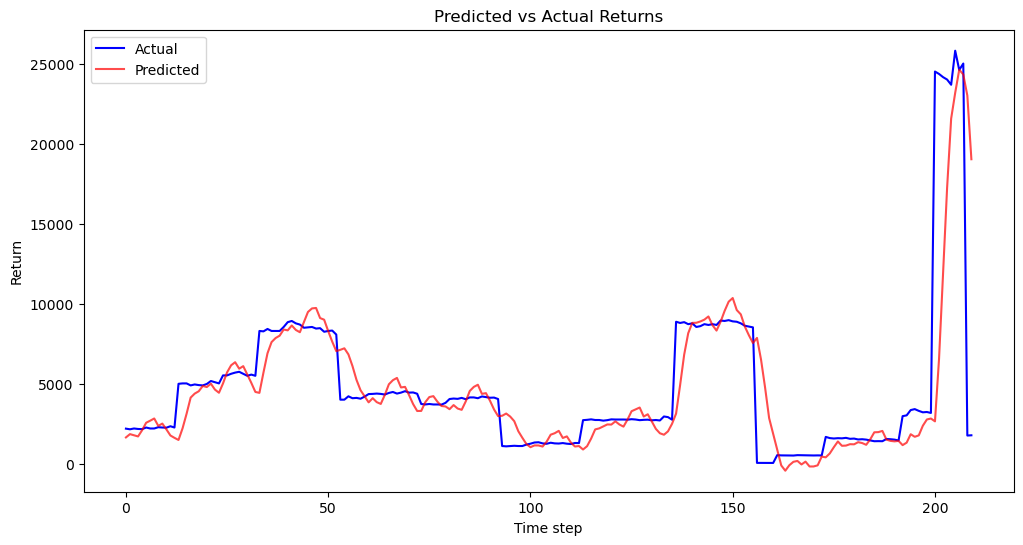

In [55]:
plt.figure(figsize=(12,6))
plt.plot(actual_returns, label='Actual', color='blue')
plt.plot(predicted_returns, label='Predicted', color='red', alpha=0.7)
plt.title("Predicted vs Actual Returns")
plt.xlabel("Time step")
plt.ylabel("Return")
plt.legend()
plt.show()

In [56]:
metrics = compute_metrics(actual_returns, predicted_returns)

print(f"RMSE  : {metrics['RMSE']:.6f}")
print(f"MAE   : {metrics['MAE']:.6f}")
print(f"MAPE  : {metrics['MAPE']:.2f}%")

RMSE  : 3163.592278
MAE   : 1254.926183
MAPE  : 222.01%


In [50]:
scores = custom_stock_score(actual_returns, predicted_returns)
print("Score per prediksi:", scores)
print("Rata-rata score:", np.mean(scores))

Score per prediksi: [ 3.43219180e-03  5.04428528e-03  1.00217513e-02  2.23838591e-03
  4.86663102e-03  4.80944229e-03  4.29818670e-02  5.99812119e-04
  1.48165243e-03  1.13910642e-03  1.32327224e-03  1.94395284e-03
  1.08407826e-03  6.18187356e-04  6.44362764e-04  2.72657626e-04
  2.87929997e-03  9.58182448e-04  9.02035747e-04  8.39078096e-04
  1.13472411e-03  1.14883854e-02  1.91846702e-03  1.06655723e-03
  4.32079361e-03  8.84321430e-02  1.38414291e-03  8.34433076e-04
  4.29257414e-03  2.78766892e-03  6.16379194e-03  8.45461732e-04
  7.16843118e-04  3.65741455e-04  3.37031963e-04  2.12559583e-04
  1.61892114e-03  6.18789819e-04  7.77769760e-04  8.08404246e-04
  1.23557640e-03  5.17603053e-03  3.65150910e-03  2.19287444e-03
  1.43751579e-02  3.10887121e-02  3.32292755e-03  9.84151698e-04
  3.30921442e-03  1.78975922e-03  3.74858147e-02  5.26119333e-04
  3.44177501e-04  2.55013988e-04  2.63829265e-04  6.66069546e-04
  3.19523710e-04  1.22308891e-03  2.62255112e-03  2.68915861e-03
  1.7

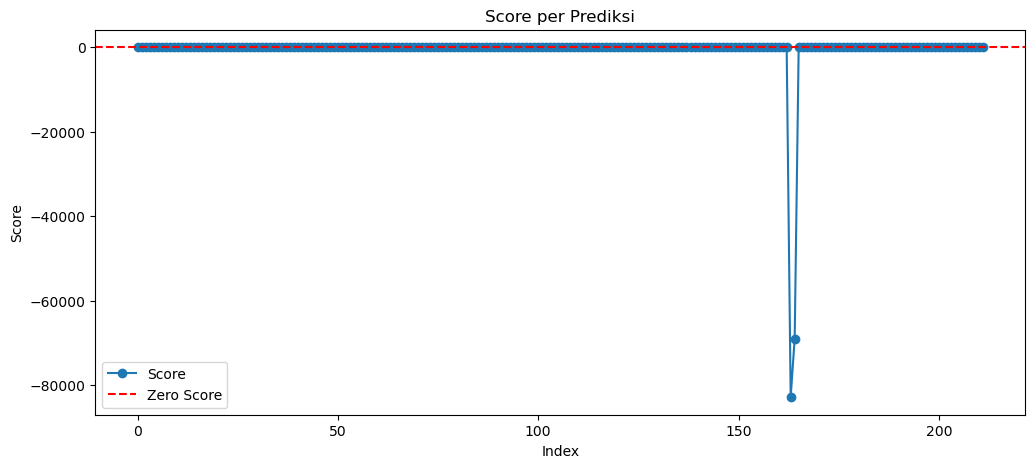

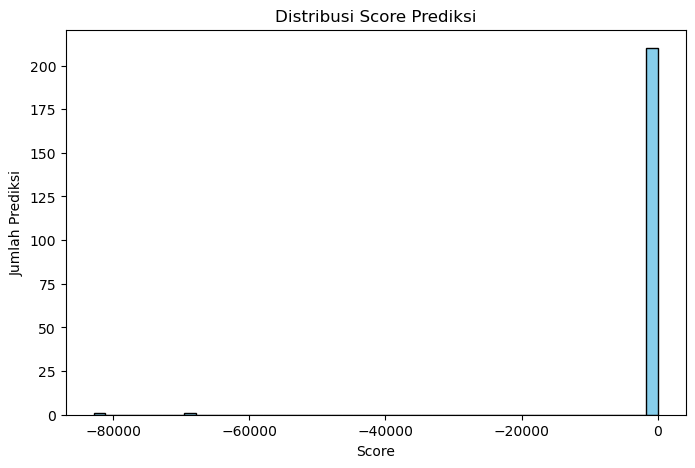

Prediksi salah arah: 2 / 212 (0.94%)


In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# x = prediksi, r = real
x = predicted_returns[:, 0]
r = actual_returns[:, 0]

# Hitung score sesuai paper
MAX = 1000  
scores = np.where(
    x*r >= 0,
    np.minimum(1/np.abs(x-r), MAX),
    -100 * np.abs(x-r)
)

score_df = pd.DataFrame({
    'Actual': r,
    'Predicted': x,
    'Score': scores,
    'Wrong_Direction': x*r < 0
})

# Plot score per index
plt.figure(figsize=(12,5))
plt.plot(score_df['Score'], label='Score', marker='o', linestyle='-')
plt.title("Score per Prediksi")
plt.xlabel("Index")
plt.ylabel("Score")
plt.axhline(0, color='red', linestyle='--', label='Zero Score')
plt.legend()
plt.show()

# Plot histogram score
plt.figure(figsize=(8,5))
plt.hist(score_df['Score'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribusi Score Prediksi")
plt.xlabel("Score")
plt.ylabel("Jumlah Prediksi")
plt.show()

# Opsional: tampilkan berapa banyak salah arah
wrong_count = score_df['Wrong_Direction'].sum()
total = len(score_df)
print(f"Prediksi salah arah: {wrong_count} / {total} ({wrong_count/total*100:.2f}%)")

Terlihat tren score tiap prediksi. Kalau banyak di bawah 0 → banyak salah arah.

### Hyperparameter Tuning


--- Time Window: 2 ---
7/7 [==============================] - 4s 8ms/step
MAE: 2568.0930, RMSE: 3361.1418, MAPE: 245.61%

--- Time Window: 3 ---
7/7 [==============================] - 4s 11ms/step
MAE: 2328.4092, RMSE: 3244.0809, MAPE: 258.63%

--- Time Window: 4 ---
7/7 [==============================] - 4s 15ms/step
MAE: 2516.4243, RMSE: 3498.3385, MAPE: 300.19%

--- Time Window: 5 ---
7/7 [==============================] - 3s 14ms/step
MAE: 1903.1670, RMSE: 3134.5035, MAPE: 254.66%

--- Time Window: 6 ---
7/7 [==============================] - 4s 15ms/step
MAE: 1637.4729, RMSE: 3227.7906, MAPE: 232.76%

--- Time Window: 7 ---
7/7 [==============================] - 4s 18ms/step
MAE: 1527.7488, RMSE: 3193.6037, MAPE: 254.60%

--- Time Window: 8 ---
7/7 [==============================] - 3s 17ms/step
MAE: 1889.5156, RMSE: 3292.0055, MAPE: 221.01%

Summary:
   time_window          MAE         RMSE        MAPE
0            2  2568.093007  3361.141770  245.608463
1            3  2328.409

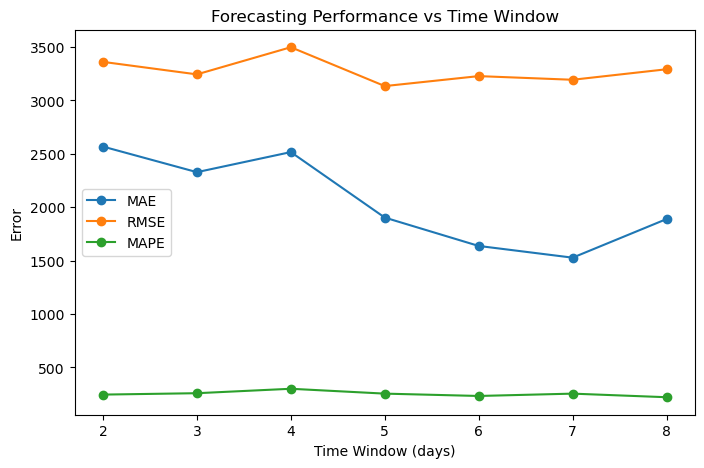

In [52]:
time_windows = range(2, 9) 
results = []

for tw in time_windows:
    print(f"\n--- Time Window: {tw} ---")
    
    X_train_seq, y_train_seq = create_dataset(X_train_scaled, y_train_scaled, tw)
    X_val_seq, y_val_seq     = create_dataset(X_val_scaled,   y_val_scaled,   tw)
    X_test_seq, y_test_seq   = create_dataset(X_test_scaled,  y_test_scaled,  tw)
    
    model = build_lstm(input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]))
    
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=50, 
        batch_size=32,
        validation_data=(X_val_seq, y_val_seq),
        verbose=0
    )
    
    preds = model.predict(X_test_seq)
    preds_inv = scaler_y.inverse_transform(preds)
    y_test_inv = scaler_y.inverse_transform(y_test_seq.reshape(-1,1))
    
    metrics = compute_metrics(y_test_inv, preds_inv)
    print(f"MAE: {metrics['MAE']:.4f}, RMSE: {metrics['RMSE']:.4f}, MAPE: {metrics['MAPE']:.2f}%")
    
    results.append({'time_window': tw, **metrics})

results_df = pd.DataFrame(results)
print("\nSummary:")
print(results_df)

plt.figure(figsize=(8,5))
plt.plot(results_df['time_window'], results_df['MAE'], marker='o', label='MAE')
plt.plot(results_df['time_window'], results_df['RMSE'], marker='o', label='RMSE')
plt.plot(results_df['time_window'], results_df['MAPE'], marker='o', label='MAPE')
plt.xlabel("Time Window (days)")
plt.ylabel("Error")
plt.title("Forecasting Performance vs Time Window")
plt.legend()
plt.show()

Time window 7 menunjukan hasil yang paling baik diantara semua time window.

### Comparing Baseline

In [58]:
time_step = 7 

# Buat dataset sequence
X_train_seq, y_train_seq = create_dataset(X_train_scaled, y_train_scaled, time_step)
X_val_seq,   y_val_seq   = create_dataset(X_val_scaled,   y_val_scaled,   time_step)
X_test_seq,  y_test_seq  = create_dataset(X_test_scaled,  y_test_scaled,  time_step)

results_models = []

# Loop semua arsitektur
for model_type, builder in [('gru', build_gru), ('bi_lstm', build_bilstm)]:
    print(f"\nTraining model: {model_type}")
    model = builder(input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]))
    
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=50,
        batch_size=32,
        verbose=0
    )
    
    preds = model.predict(X_test_seq)
    preds_inv = scaler_y.inverse_transform(preds)
    y_test_inv = scaler_y.inverse_transform(y_test_seq.reshape(-1,1))
    
    metrics = compute_metrics(y_test_inv, preds_inv)
    print(f"{model_type}: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}, MAPE={metrics['MAPE']:.2f}%")
    
    results_models.append({'Model': model_type, **metrics})

# Ringkasan hasil
results_df = pd.DataFrame(results_models)
print("\nSummary of all models:")
print(results_df)


Training model: gru
7/7 [==============================] - 2s 10ms/step
gru: MAE=1213.9893, RMSE=2568.4588, MAPE=175.38%

Training model: bi_lstm
7/7 [==============================] - 3s 11ms/step
bi_lstm: MAE=1791.8502, RMSE=3414.7495, MAPE=245.59%

Summary of all models:
     Model          MAE         RMSE        MAPE
0      gru  1213.989278  2568.458804  175.377403
1  bi_lstm  1791.850171  3414.749506  245.589460


--------------------------------------

Metrics Evaluation dari Proposed LSTM 

MAE   : 1254.926183
RMSE  : 3163.592278
MAPE  : 222.01%

Terlihat bahwa, sebenarnya untuk dataset kali ini model dengan hasil evaluasi yang baik adalah dengan GRU.

In [61]:
df_test = df[df['split']=='TEST'].copy()

X_test = df_test[features].values.astype(float)
X_test = clean_array(X_test)
X_test_scaled = scaler_X.transform(X_test)

y_test = df_test['Close'].values.reshape(-1,1).astype(float)
y_test = clean_array(y_test)
y_test_scaled = scaler_y.transform(y_test)

X_test_seq, y_test_seq = create_dataset(X_test_scaled, y_test_scaled, time_step)

preds_scaled = model.predict(X_test_seq)
preds = scaler_y.inverse_transform(preds_scaled)
y_test_inv = scaler_y.inverse_transform(y_test_seq.reshape(-1,1))

df_test_seq = df_test.iloc[time_step:].copy()
df_test_seq['predicted_Close'] = preds

def calc_metrics(group):
    return pd.Series(compute_metrics(group['Close'].values, group['predicted_Close'].values))

results_per_ticker = df_test_seq.groupby('Ticker').apply(calc_metrics).reset_index()

print(results_per_ticker)

avg_metrics = results_per_ticker[['MAE','RMSE','MAPE']].mean()
print("\nAverage metrics:", avg_metrics)

7/7 [==============================] - 0s 8ms/step
     Ticker      MAE     RMSE    MAPE
0   ARTO.JK  1018.69  1257.37   45.42
1   ASII.JK  1053.32  1667.50   20.49
2   BBCA.JK  1269.02  1512.17   15.08
3   BBNI.JK  1144.18  1649.90   27.32
4   BBRI.JK   520.41   807.52   13.01
5   BBTN.JK  1085.63  1266.38   87.59
6   BRIS.JK  1082.15  1501.76   39.48
7   EXCL.JK  2021.92  2060.11   69.87
8   GGRM.JK  1235.47  1826.20   14.07
9   GOTO.JK  4256.89  5055.82 7004.01
10  HMSP.JK  2715.47  2765.56  511.15
11  PGEO.JK  1853.62  2090.92  119.22
12  TLKM.JK  2202.10  2497.21   69.49
13  UNTR.JK  7927.52 11033.48   32.51
14  UNVR.JK 19525.21 19701.13 1099.11

Average metrics: MAE    3260.77
RMSE   3779.54
MAPE    611.19
dtype: float64


### Daily Advice

In [237]:
# --- Parameters ---
K = 1  # jumlah saham yang akan disarankan
time_step = 5  # sesuai LSTM

# --- Ambil dataframe test set September ---
df_sep = df[df['Date'] >= '2025-09-01'].copy()
df_sep['Date'] = pd.to_datetime(df_sep['Date'])

# --- Ambil fitur dan lakukan scaling ---
X_sep = df_sep[features].values.astype(float)
X_sep = clean_array(X_sep)
X_sep_scaled = scaler_X.transform(X_sep)

# --- Buat sequence LSTM untuk prediksi ---
def create_dataset_single(X, time_step=5):
    Xs = []
    for i in range(time_step, len(X)):
        Xs.append(X[i-time_step:i, :])
    return np.array(Xs)

X_sep_seq = create_dataset_single(X_sep_scaled, time_step)

# --- Predict Close price ---
preds_scaled = model.predict(X_sep_seq)
preds = scaler_y.inverse_transform(preds_scaled)

# --- Buat dataframe prediksi per tanggal & ticker ---
df_pred = df_sep.iloc[time_step:].copy()
df_pred['predicted_Close'] = preds

# --- Buat Advice Unit berdasarkan predicted Close ---
advice_list = []

for date, group in df_pred.groupby('Date'):
    top_k = group.sort_values('predicted_Close', ascending=False).head(K)
    stocks_str = " - ".join(top_k['Ticker'].tolist())
    avg_close = top_k['predicted_Close'].mean()  
    advice_list.append({'Date Traded': date.strftime('%d-%m-%Y'),
                        'Stocks': stocks_str,
                        'Predicted Close': round(avg_close, 2)})

# --- Hasil akhir ---
df_advice = pd.DataFrame(advice_list)
print(df_advice)

5/5 [==============================] - 0s 22ms/step
   Date Traded   Stocks  Predicted Close
0   01-09-2025  BBNI.JK         12285.63
1   02-09-2025  GOTO.JK         16362.86
2   03-09-2025  BBCA.JK         10577.97
3   04-09-2025  BBCA.JK         11873.82
4   08-09-2025  BBCA.JK         13166.28
5   09-09-2025  GGRM.JK         12716.37
6   10-09-2025  GGRM.JK         14381.22
7   11-09-2025  GGRM.JK         13653.36
8   12-09-2025  GGRM.JK         14486.49
9   15-09-2025  GGRM.JK         15676.38
10  16-09-2025  BBCA.JK         12937.68
11  17-09-2025  UNTR.JK         18685.53
12  18-09-2025  UNTR.JK         25839.24
13  19-09-2025  GGRM.JK         15285.69


In [64]:
df_advice = generate_daily_advice(
    df=df[df['Date'] >= '2025-09-01'],  
    model=model,
    scaler_X=scaler_X,
    scaler_y=scaler_y,
    features=features,
    time_step=7,
    top_k=2
)

print(df_advice)

5/5 [==============================] - 0s 12ms/step
   Date Traded             Stocks  Predicted Close
0   01-09-2025  BBNI.JK - BBCA.JK          7283.36
1   02-09-2025  GOTO.JK - BBNI.JK          9474.14
2   03-09-2025  BBCA.JK - BBNI.JK          7366.23
3   04-09-2025  GOTO.JK - BBCA.JK          8145.75
4   08-09-2025  BBCA.JK - GGRM.JK          7287.77
5   09-09-2025  BBCA.JK - GGRM.JK          8366.57
6   10-09-2025  GGRM.JK - BBCA.JK          9877.68
7   11-09-2025  GGRM.JK - BBCA.JK          9834.84
8   12-09-2025  GGRM.JK - BBCA.JK          9708.21
9   15-09-2025  GGRM.JK - BBCA.JK          9496.09
10  16-09-2025  BBCA.JK - ASII.JK          7950.46
11  17-09-2025  UNTR.JK - GGRM.JK         10653.20
12  18-09-2025  UNTR.JK - GGRM.JK         13160.04
13  19-09-2025  GGRM.JK - BBCA.JK          9701.39
